# Trabalho 2 da disciplina Aprendizado de Máquina, constante da ementa do mestrado em ciência da computação no CEFET-RJ.
Professor: Eduardo Bezerra      
    
Aluna: Francimary Garcia
    
Entrega: 31/10/2017

# 1 Regressão Logística com Regularização

# Implementar a regressão logística regularizada para prever se os microchips de uma usina de fabricação passam na garantia de qualidade (QA). 
Durante a QA, cada microchip passa por vários testes para garantir se está funcionando corretamente. Suponha que você seja o gerente de produto da fábrica e você tem os resultados de teste para alguns microchips em dois testes diferentes. A partir desses dois testes, você gostaria de determinar se os microchips deveriam ser aceitos ou rejeitados. Para ajudá-lo a tomar a decisão, você tem um conjunto de dados de resultados de testes anteriores sobre microchips, a partir do qual você pode construir um modelo de regressão logística. 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import csv
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import os 
import scipy.optimize as opt  
%matplotlib inline


from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

Leitura dos dados do arquivo fornecido contendo os resultados obtidos nos testes 1 e 2 e o status de aceitação(1) ou rejeição(0) do produto.

In [6]:
arquivo = 'C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex2data2.txt'

ficheiro = open(arquivo, "r")

dados = pd.read_csv(ficheiro, names = ['Teste1', 'Teste2','Status'])

dados.head()

,Teste1,Teste2,Status
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [7]:
y = np.c_[dados.values[:,2]]
X = dados.values[:,0:2]

In [8]:
positive = dados[dados['Status'].isin([1])]  
negative = dados[dados['Status'].isin([0])]

# 1.1 - Visualização dos Dados

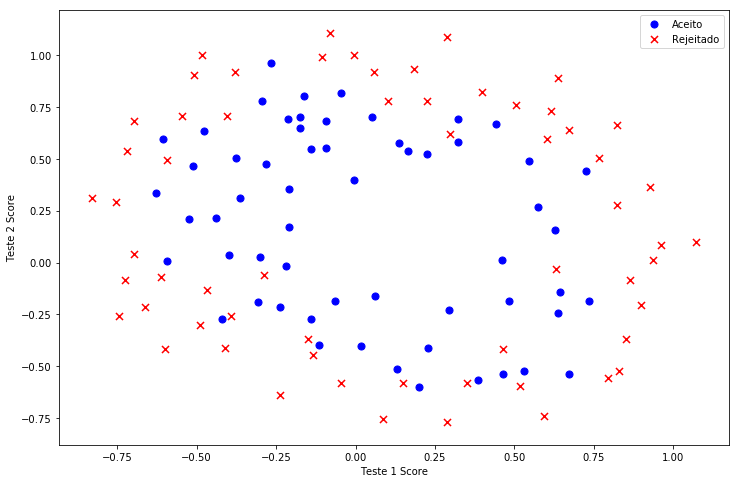

In [9]:
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Teste1'], positive['Teste2'], s=50, c='b', marker='o', label='Aceito')  
ax.scatter(negative['Teste1'], negative['Teste2'], s=50, c='r', marker='x', label='Rejeitado')  
ax.legend()  
ax.set_xlabel('Teste 1 Score')  
ax.set_ylabel('Teste 2 Score')  

Pela visualização do gráfico de dispersão acima, podemos notar que não existe uma distribuição linear entre os dados fornecidos e nem mesmo existe um limite de decisão linear que funcione bem nesses dados. Para cenários desta natureza uma maneira de lidarmos é construir atributos que são derivados de polinômios dos atributos originais. Alimentando o classificador com uma boa quantidade de atributos polinomiais.

# 1.2 - Mapeamento de características (feature mapping)

Nesta seção acrescentaremos novas características ao vetor dado, derivadas das características originais do mesmo.
Como mostrado abaixo, partiremos de um vetor com 3 características para um vetor com 28 dimensões,  pois o mesmo mapeará as características para todos os termos polinomiais de x1 e x2, até a sexta potência.

Um classiﬁcador que usa regressão logística treinado nesse vetor de características de maior dimensão terá uma fronteira de decisão mais complexa e parecerá não linear quando desenhado em um gráﬁco bidimensional.
Embora o mapeamento de características nos permita construir um classiﬁcador mais expressivo, também é mais suscetível a sobreajuste (overﬁtting). 

In [10]:
dados.shape

(118, 3)

In [11]:

# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
XX = poly.fit_transform(dados.values[:,0:2])
XX.shape


(118, 28)

# 1.3 Função de custo e gradiente


Implementar o código para calcular a função de custo e o gradiente para a regressão logística "regularizada".

As novas funções de Custo e Gradiente implementadas possuem uma nova variável chamada "reg" que é uma função dos valores dos parâmetros. 
À medida que os parâmetros aumentam, a penalização adicionada à função de custo aumenta. 


In [12]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

In [13]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [14]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [15]:
initial_theta = np.zeros(XX.shape[1])

print("O erro para o modelo com theta igual a zero é: %.4f" %costFunctionReg(initial_theta, 1, XX, y))

O erro para o modelo com theta igual a zero é: 0.6931



Utilizando opt.fmin_tnc para minimizar uma função com variáveis ​​sujeitas a limites, usando informações de gradiente em um algoritmo Newton truncado e encontrar os parâmetros para o modelo ótimo.

In [21]:
result2 = opt.fmin_tnc(func=costFunctionReg, x0=initial_theta, fprime=gradientReg, args=(XX.all(),y, 1)) 
result2 

(array([ 1.27271026,  0.62529964,  1.18111686, -2.01987399, -0.91743189,
        -1.43166929,  0.12393228, -0.36553118, -0.35725405, -0.17516291,
        -1.45817009, -0.05098418, -0.61558559, -0.27469165, -1.19271299,
        -0.24217841, -0.20603304, -0.04466177, -0.27778946, -0.29539514,
        -0.45645982, -1.04319154,  0.02779373, -0.29244863,  0.01555759,
        -0.32742403, -0.14389149, -0.92467488]), 32, 1)

# 1.4 Esboço da fronteira de decisão


Esboçar a fronteira de decisão que foi aprendida para separar os exemplos positivos dos negativos.

In [31]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data.values[:,2] == 0
    pos = data.values[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data.values[pos][:,0], data.values[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data.values[neg][:,0], data.values[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

C:\Users\Raymundo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


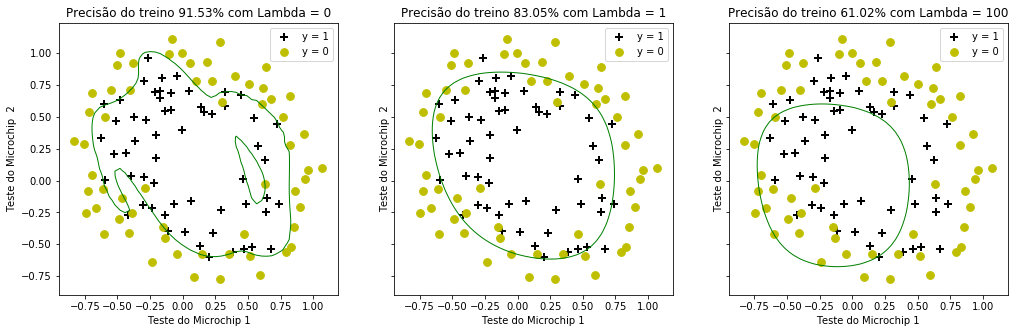

In [33]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, 
                    options={'maxiter':3000})
    
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size  
    
 # Scatter plot of X,y
    plotData(dados, 'Teste do Microchip 1', 'Teste do Microchip  2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Precisão do treino {}% com Lambda = {}'.format(np.round(accuracy, decimals=2), C))

Nos gráficos acima podemos observar o comportamento do modelo para os três valores de Lambda. Com o Lambda=0 observamos o comportamento de sobreajuste, com o Lambda=1 o comportamento mais ajustado e com Lambda = 100 o comportamento com alto viés. 

# 2 Regressão Linear com Regularização

Implementar a regressão linear com regularização para prever a quantidade de água ﬂuindo de uma barragem usando a mudança do nível da água em um reservatório.
Além de realizar diagnósticos dos algoritmos de aprendizado por meio de depuração e examinar os efeitos de viés (bias) e da variância (variance)

In [34]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns

O arquivo de dados fornecido possui registros históricos na mudança no nível da água, x, e da quantidade de água que sai da barragem, y. Este conjunto de dados é dividido em três partes:

    Treinamento: x e y
    Validação: Xval e Yval e
    Teste: Xtest e Ytest


In [41]:

data = loadmat('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex5data1.mat')

data.keys()

y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data['yval']
Xval = np.c_[np.ones_like(data['Xval']), data['Xval']]

ytest = data['ytest']
Xtest = np.c_[np.ones_like(data['Xtest']), data['Xtest']]


print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)
print('Xtest:', Xtest.shape)
print('ytest:', ytest.shape)


X_train: (12, 2)
y_train: (12, 1)
Xval: (21, 2)
yval: (21, 1)
Xtest: (21, 2)
ytest: (21, 1)


# 2.1 Visualização dos Dados


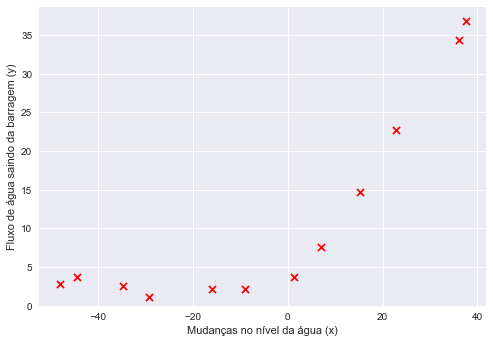

In [42]:
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Mudanças no nível da água (x)')
plt.ylabel('Fluxo de água saindo da barragem (y)')
plt.ylim(ymin=0);


Acima visualização dos dados de treinamento.

# 2.2 Função de custo da regressão linear regularizada


Escrever uma função para calcular a função de custo da regressão linear regularizada. 

In [43]:
def linearRegCostFunction(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta)
    
    J = (1/(2*m))*np.sum(np.square(h-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
   
    return(J)

In [44]:
def lrgradientReg(theta, X, y, reg):
    m = y.size
    
    h = X.dot(theta.reshape(-1,1))
        
    grad = (1/m)*(X.T.dot(h-y))+ (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [45]:
initial_theta = np.ones((X_train.shape[1],1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)

print(cost)


303.951525554


# 2.3 Gradiente na regressão linear regularizada


In [46]:
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)
print(gradient)

[ -15.30301567  598.16741084]


# 2.4 Ajustando os parâmetros da regressão linear


In [188]:
def trainLinearReg(X, y, reg):
    #initial_theta = np.zeros((X.shape[1],1))
    initial_theta = np.array([[15],[15]])
    # For some reason the minimize() function does not converge when using
    # zeros as initial theta.
        
    res = minimize(linearRegCostFunction, initial_theta, args=(X,y,reg), method=None, jac=lrgradientReg,
                   options={'maxiter':5000})
    
    return(res)

In [189]:
fit = trainLinearReg(X_train, y_train, 0)
fit

      fun: 1604.4002999186634
 hess_inv: array([[ 1.03142187,  0.00617881],
       [ 0.00617881,  0.001215  ]])
      jac: array([  3.42437190e-12,  -5.70371898e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 13.08790351,   0.36777923])

In [192]:
regr = LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train.ravel())
print(regr.coef_)
print(linearRegCostFunction(regr.coef_, X_train, y_train, 0))

[ 13.08790351   0.36777923]
1604.40029992


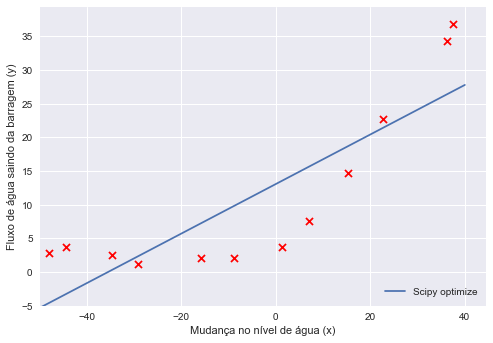

In [194]:
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label='Scipy optimize')
#plt.plot(np.linspace(-50,40), (regr.coef_[0]+ (regr.coef_[1]*np.linspace(-50,40))), label='Scikit-learn')
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Mudança no nível de água (x)')
plt.ylabel('Fluxo de água saindo da barragem (y)')
plt.ylim(ymin=-5)
plt.xlim(xmin=-50)
plt.legend(loc=4);

# 3 Viés-Variância

# 3.1 Curvas de Aprendizado


In [195]:
def learningCurve(X, y, Xval, yval, reg):
    m = y.size
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in np.arange(m):
        res = trainLinearReg(X[:i+1], y[:i+1], reg)
        error_train[i] = linearRegCostFunction(res.x, X[:i+1], y[:i+1], reg)
        error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
    
    return(error_train, error_val)

In [196]:
t_error, v_error = learningCurve(X_train, y_train, Xval, yval, 0)

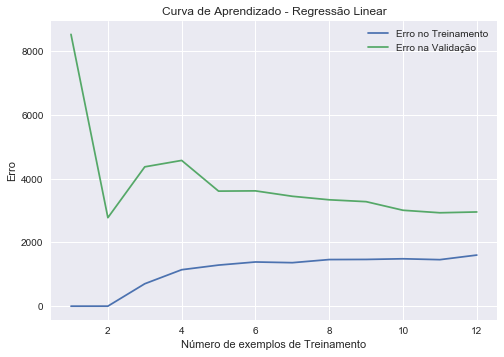

In [199]:
plt.plot(np.arange(1,13), t_error, label='Erro no Treinamento')
plt.plot(np.arange(1,13), v_error, label='Erro na Validação')
plt.title('Curva de Aprendizado - Regressão Linear')
plt.xlabel('Número de exemplos de Treinamento')
plt.ylabel('Erro')
plt.legend();

# 4 Regressão Polinomial


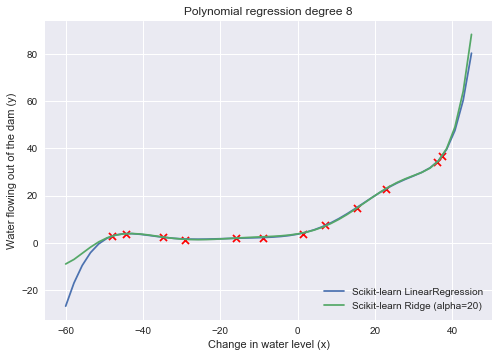

In [200]:
poly = PolynomialFeatures(degree=8)
X_train_poly = poly.fit_transform(X_train[:,1].reshape(-1,1))

regr2 = LinearRegression()
regr2.fit(X_train_poly, y_train)

regr3 = Ridge(alpha=20)
regr3.fit(X_train_poly, y_train)

# plot range for x
plot_x = np.linspace(-60,45)
# using coefficients to calculate y
plot_y = regr2.intercept_+ np.sum(regr2.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)

plt.plot(plot_x, plot_y, label='Scikit-learn LinearRegression')
plt.plot(plot_x, plot_y2, label='Scikit-learn Ridge (alpha={})'.format(regr3.alpha))
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial regression degree 8')
plt.legend(loc=4);

# 5 Regressão Polinomial - Aprendizado


Falta inserir esta parte

# Parte 2 do Trabalho 2

Implementar o algoritmo de detecção de anomalia e aplicá-lo para detectar servidores com falha em uma rede. 
Na segunda parte, usar a filtragem colaborativa para criar um sistema de recomendação para filmes.

# 2- Detecção de Anomalias

Implementar um algoritmo de detecção de anomalia para detectar comportamentos anômalos nos servidores de um centro de dados. 
As características medem a vazão (throughput) (mb/s) e a latência (ms) de resposta de cada servidor. Enquanto seus servidores estavam funcionando, 
foram coletados m = 307 exemplos de como eles estavam se comportando. Há a suspeita de que a grande maioria desses exemplos são exemplos ”normais”(não
anômalos) dos servidores que operam normalmente, mas também pode haver alguns exemplos de servidores que atuam de forma anômala nesse conjunto de
dados.
Usar um modelo gaussiano para detectar exemplos anômalos em seu conjunto de dados. Usar um conjunto de dados 2D que permitirá a visualização
do que o algoritmo está fazendo. Nesse conjunto de dados, ajustar uma distribuição gaussiana e então encontrar valores que têm probabilidade
muito baixa e, portanto, podem ser considerados anomalias.

# 2.1 Distribuição Gaussiana

Dado um conjunto de treinamento {x(1), . . . , x(m)} (onde x(i) ∈ Rn), estimar a distribuição gaussiana para cada uma das características xj .
Para cada característica j = 1, . . . , n, encontrar os parâmetros µj e σ2j que se encaixam nos dados na j-ésima dimensão x(1), ..., x(m) (a j-ésima dimensão de cada exemplo).
A distribuição gaussiana é dada por
p(x; µ, σ2) = 1√2πσexp −(x − µ)22σ2

In [107]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
from scipy.io import loadmat  
%matplotlib inline


In [108]:
data = loadmat('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex8data1.mat')  
X = data['X']  
X.shape 

(307, 2)

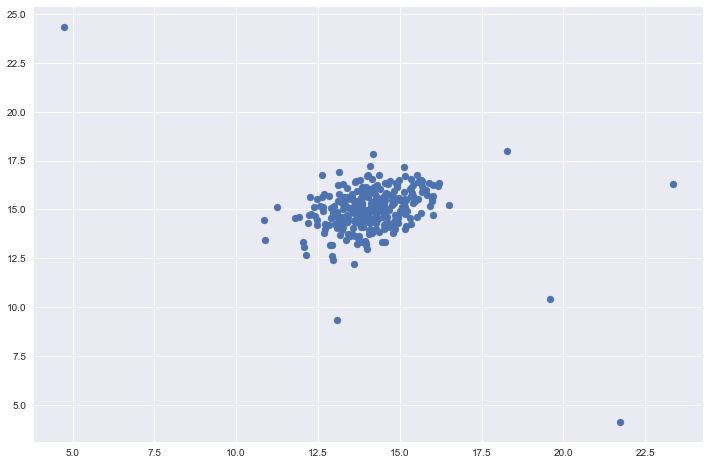

In [109]:
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(X[:,0], X[:,1]) 

Pelo gráfico acima podemos identificar a existência de um agrupamento de dados em uma região central, com alguns valores mais longe do agrupamento. Neste exemplo, os pontos mais afastados podem ser considerados anomalias. Para concluirmos essa dedução, devemos estimar uma distribuição gaussiana para cada característica nos dados.

# 2.2 Estimativa de parâmetros para uma gaussiana

Estimar os parâmetros, (µj , σ2j), da j-ésima característica usando as equações apresentadas em aula.
A tarefa é implementar uma função estimativaGaussiana que toma como entrada a matriz de dados X e deve produzir um vetor de dimensão n mu
que contém a média de todas as características n e outro vetor de dimensão n sigma2 que contém as variâncias de todas as características.


In [110]:
def estimativaGaussiana(X):  
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)

    return mu, sigma

mu, sigma = estimativaGaussiana(X)  
mu, sigma  

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

# 2.3 Selecionando E

Agora que os parâmetros gaussianos foram avaliados, você pode investigar quais exemplos têm uma probabilidade muito alta dada essa distribuição e quais
exemplos têm uma probabilidade muito baixa. Os exemplos de baixa probabilidade
são mais prováveis de ser as anomalias em nosso conjunto de dados. Uma maneira de determinar quais exemplos são anomalias é selecionar um limite E com base em um conjunto de validação cruzada. Nesta parte do exercício,
deve ser implementado um algoritmo para selecionar o limite E usando a medida F1 em um conjunto de validação cruzada. Implementar código em um arquivo de nome selectThreshold.py. Para isso, usar um conjunto de validação cruzada 
{(x(1)cv , y(1)cv ), . . . , x(m)cv , y(m)cv )}, onde o rótulo y = 1 corresponde a um exemplo anômalo. Para cada exemplo no conjunto de validação, deve-se computar Pr(x(i)cv ). O vetor de todas essas probabilidades 
Pr(x(1)cv ), . . . , Pr(x(mcv)cv ), assim como os rótulos correspondentes, devem ser passados a função implementada
em selectThreshold.py.

In [111]:
Xval = data['Xval']  
yval = data['yval']

Xval.shape, yval.shape  

((307, 2), (307, 1))

Abaixo está o cálculo da probabilidade de um ponto de dados pertencer a uma distribuição normal. A função stats.norm do SciPy realiza esta atividade.

In [114]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
print("Probabilidade de um ponto de dados pertencer a Normal:%.4f" %dist.pdf(15))


Probabilidade de um ponto de dados pertencer a Normal:0.1936


Também podemos passar em uma matriz para a função de densidade de probabilidade e obter a densidade de probabilidade em todos os pontos do conjunto de dados.

In [115]:

dist.pdf(X[:,0])[0:50]  

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

Vamos calcular e salvar a densidade de probabilidade de cada um dos valores em nosso conjunto de dados, dados os parâmetros do modelo gaussiano que calculamos acima.

In [116]:

p = np.zeros((X.shape[0], X.shape[1]))  
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])  
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape 

(307, 2)

Também precisamos fazer isso para o conjunto de validação (usando os mesmos parâmetros do modelo). Usaremos essas probabilidades combinadas com o rótulo verdadeiro para determinar o limite de probabilidade ótimo para atribuir pontos de dados como anomalias.

In [117]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))  
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])  
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])  
pval.shape

(307, 2)

A função selectThreshold deve retornar dois valores; o primeiro é o limite selecionado E. Se um exemplo x tiver uma baixa probabilidade Pr(x) < E, então
é considerado uma anomalia. A função também deve retornar a pontuação F1,
o que indica o quão bem você está realizando a tarefa de encontrar as anomalias verdadeiras, dado um determinado limite. Para muitos valores diferentes de E,
calcular o resultado F1 resultante ao calcular quantos exemplos o limite atual classifica corretamente e incorretamente.


Precisamos de uma função que encontre o melhor valor limiar, dados os valores de densidade de probabilidade e os rótulos verdadeiros. Para fazer isso, calcularemos a pontuação F1 para valores variáveis de epsilon. F1 é uma função do número de verdadeiros positivos, falsos positivos e falsos negativos. 

In [118]:
def select_threshold(pval, yval):  
    best_epsilon = 0
    best_f1 = 0
    f1 = 0

    step = (pval.max() - pval.min()) / 1000

    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon

        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon

    return best_epsilon, best_f1

epsilon, f1 = select_threshold(pval, yval)  
epsilon, f1  

C:\Users\Raymundo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.0095667060059568421, 0.7142857142857143)

Podemos aplicar o limiar ao conjunto de dados e visualizar os resultados.

In [119]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

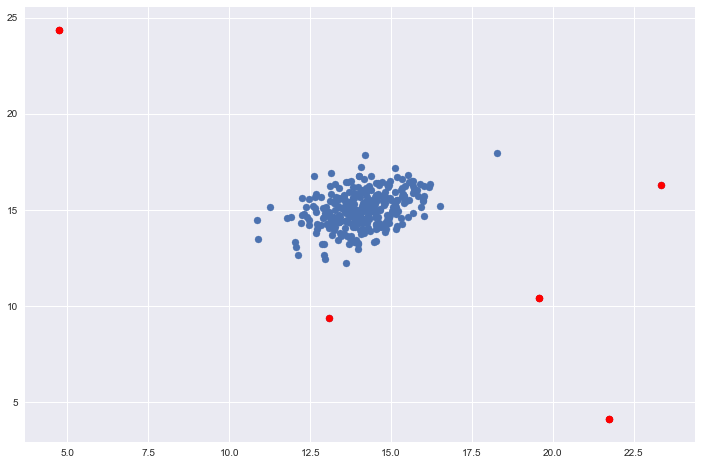

In [120]:

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(X[:,0], X[:,1])  
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')  

# Avaliando os dados de Validação Cruzada.

In [129]:
data = loadmat('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].flatten()

In [130]:
#  Apply the same steps to the larger dataset
mu, sigma2 = estimativaGaussiana(X)

In [131]:
def multivariateGaussian(X, mu, Sigma2):
    """Computes the probability
    density function of the examples X under the multivariate gaussian
    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    treated as the covariance matrix. If Sigma2 is a vector, it is treated
    as the \sigma^2 values of the variances in each dimension (a diagonal
    covariance matrix)
    """
    k = len(mu)

    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * \
        np.exp(-0.5 * np.sum(X.dot(np.linalg.pinv(Sigma2))*X, axis=1))

    return p

In [132]:
#  Training set 
p = multivariateGaussian(X, mu, sigma2)


In [133]:
#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)


In [134]:
#  Find the best threshold
epsilon, F1 = select_threshold(pval,yval)
epsilon, F1

C:\Users\Raymundo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(1.3772288907613579e-18, 0.61538461538461542)

In [135]:
print ("Melhor Epsilon usando a Validação Cruzada: %e" % epsilon)
print ("Melhor F1 no conjunto de Validação Cruzada:  %f" % F1)
print ("# Quantidade de Outliers: %d" % sum(p < epsilon))


Melhor Epsilon usando a Validação Cruzada: 1.377229e-18
Melhor F1 no conjunto de Validação Cruzada:  0.615385
# Quantidade de Outliers: 117


# 3 Sistemas de Recomendação

Implementar o algoritmo de aprendizagem de filtragem colaborativa e aplicá-lo a um conjunto de dados de avaliações de filmes. 
Este conjunto de dados consiste em classificações em uma escala de 1 a 5. O conjunto de dados tem nu = 943 usuários e nm = 1682 filmes. O arquivo que contém o
conjunto de dados tem nomee ex8 movies.mat, contém as variáveis Y e R.

In [136]:
data = loadmat('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex8_movies.mat')  
data  

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y é uma matriz de (número de filmes x número de usuários) contendo classificações de 1 a 5. R é uma matriz "indicador" contendo valores binários indicando se um usuário classificou um filme ou não. Ambos devem ter a mesma forma.

In [138]:
Y = data['Y']  
R = data['R']  
Y.shape, R.shape  

((1682, 943), (1682, 943))

Podemos observar a classificação média de um filme com uma média de uma linha em Y para índices onde uma classificação está presente.

In [141]:
print(" Classificação média dos filmes:%.4f" %Y[1,R[1,:]].mean()  )

 Classificação média dos filmes:2.5832


Também podemos tentar "visualizar" os dados, representando a matriz como se fosse uma imagem. Não podemos tirar muito disso, mas nos dá uma idéia de uma densidade relativa de classificações entre usuários e filmes.

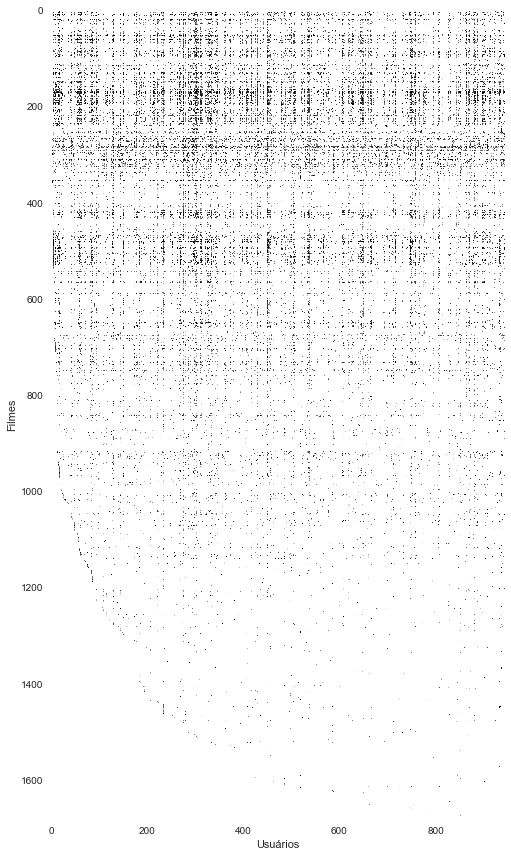

In [142]:
fig, ax = plt.subplots(figsize=(12,12))  
ax.imshow(Y)  
ax.set_xlabel('Usuários')  
ax.set_ylabel('Filmes')  
fig.tight_layout() 

Abaixo implementação da função de custo para filtragem colaborativa. Intuitivamente, o "custo" é o grau em que um conjunto de previsões de classificação de filmes se desviam das previsões verdadeiras. A equação de custo é dada no texto do exercício. Baseia-se em dois conjuntos de matrizes de parâmetros denominados X e Theta no texto. Estes são "desenrolados" na entrada "params" para que possamos usar o pacote de otimização da SciPy mais tarde. 

In [143]:
def cost(params, Y, R, num_features):  
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]

    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)

    # initializations
    J = 0

    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)

    return J

Para fazer teste, utilizaremos um conjunto de parâmetros pré-treinados que podemos avaliar. Para reduzir o tempo de avaliação, analisaremos apenas um pequeno subconjunto dos dados.

In [144]:
users = 4  
movies = 5  
features = 3

params_data = loadmat('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\ex8_movieParams.mat')  

X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape


((1682, 10), (943, 10))

In [146]:
X_sub = X[:movies, :features]  
Theta_sub = Theta[:users, :features]  
Y_sub = Y[:movies, :users]  
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

print("Custo da Filtragem Colaborativa: %.4f" %cost(params, Y_sub, R_sub, features)  )

Custo da Filtragem Colaborativa: 22.2246


A função de custo será expandida para calcular também os gradientes.

In [148]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [149]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

Agora a implementação da função de Custo adicionará regularização tanto ao custo como ao cálculo de gradientes. 

In [150]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [151]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [152]:
movie_idx = {}
f = open('C:\\\\Users\\\\Raymundo\\\\Documents\\\\Franci\\\\MestradoCEFET\\\\7 Aprendizado de Máquina\\\\Trabalho 2\\\\movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [153]:
movie_idx[0]

'Toy Story (1995)'

In [154]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [155]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

In [156]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [157]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.5070364565159845e-19

In [158]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38970.7843706566
     jac: array([-0.0824164 ,  0.07252796,  0.089117  , ..., -0.02125572,
        0.0213976 , -0.00922454])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 151
     nit: 100
    njev: 151
  status: 1
 success: False
       x: array([ 0.83080694, -0.34350207,  0.02620918, ..., -0.09008132,
        0.1250956 ,  0.03311438])

In [159]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

In [160]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682, 1)

In [161]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[ 5.00000404],
        [ 5.0000008 ],
        [ 5.00000048],
        [ 5.00000039],
        [ 5.00000029],
        [ 4.99999986],
        [ 4.99999865],
        [ 4.99999848],
        [ 4.99999737],
        [ 4.99999386]])

In [162]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1200],
        [1652],
        [1292],
        ..., 
        [1492],
        [ 313],
        [1493]], dtype=int64)

In [163]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.00000404039732 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000000800969988 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 5.000000478485963 for movie Star Kid (1997).
Predicted rating of 5.000000387292753 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.000000290197792 for movie Aiqing wansui (1994).
Predicted rating of 4.999999859440371 for movie They Made Me a Criminal (1939).
Predicted rating of 4.9999986514204995 for movie Someone Else's America (1995).
Predicted rating of 4.999998484487046 for movie Santa with Muscles (1996).
Predicted rating of 4.999997373646795 for movie Great Day in Harlem, A (1994).
Predicted rating of 4.999993856093008 for movie Prefontaine (1997).
